# Вычисление полной синхронизации по всем данным

 - state1 - глаза открыты
 - state2 - открыты в темноте
 - state3 - закрыты в темноте
 
 ![alt text](https://www.researchgate.net/publication/283553087/figure/fig11/AS:669589767729180@1536654049961/EEG-electrodes-location-of-international-10-20-system.png)

In [114]:
import pickle
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pymc3 as pm
import arviz as az
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)
%matplotlib inline

In [145]:
import warnings
warnings.filterwarnings('ignore')

In [115]:
from extract_statistics import mean_coeff, compute_diff, coeff_channel, mean_coeff, mean_coeff_channel

In [116]:
with open('ispc_all.pickle', 'rb') as handle:
    ispc_all = pickle.load(handle)

In [338]:
chan_dict = {0: 'Fp1-Ref', 1: 'Fp2', 2: 'F7', 3: 'F3', 4: 'Fz', 5: 'F4', 6: 'F8', 7: 'T3', 8: 'C3',
                          9: 'Cz', 10: 'C4',
                          11: 'T4', 12: 'T5', 13: 'P3', 14: 'Pz', 15: 'P4', 16: 'T6', 17: 'O1', 18: 'O2'}

## Подготовка данных. Вычисление кандидатов.

Открывание глаз в темноте приводит к уменьшению синхронизации по всем частотам и всем каналам

Как тестировалось:
 - были посчитаны pli и ispc синхронизация по всему людям по всей длине каналов.
 - для каждого человека была вычислена разность между всеми состояниями
 - перебором для средней синхронизации вдоль канала и по всем каналам были получены кандидаты на проверку 
 


Если сравнивать усредненный коэффициент синхронизации по всем каналам, то разницы не видно. Разницы очень маленькие, особого смысла проверять дальше нечего и делать групповой анализ тоже

In [239]:
def compare_total(data):
    states = [('state2','state3'),('state1','state3'),('state1','state2')]
    cortype = ['ispc','pli']
    index_  = pd.MultiIndex.from_product([states, cortype],
                           names=['states', 'cortype'])
    diff_list = []
    for state, cortype in index_:
        diff_list.append(compute_diff(ispc_all, mean_coeff, state1=state[0], state2=state[1], cortype=cortype).mean())
    
    return pd.DataFrame(diff_list, index = index_)

In [240]:
compare_total(ispc_all)

f_3       f_6       f_9      f_12      f_16  \
states           cortype                                                     
(state2, state3) ispc    -0.014332 -0.014063  0.007715  0.011772  0.009662   
                 pli     -0.002043 -0.000243  0.026054  0.022006  0.009409   
(state1, state3) ispc    -0.012258  0.007667  0.047457  0.056372  0.025278   
                 pli     -0.005620  0.002583  0.067052  0.060256  0.013988   
(state1, state2) ispc     0.002074  0.021730  0.039743  0.044599  0.015616   
                 pli     -0.003577  0.002826  0.040999  0.038250  0.004579   

                              f_25      f_35  
states           cortype                      
(state2, state3) ispc     0.009256  0.017746  
                 pli      0.001221  0.001692  
(state1, state3) ispc     0.011321  0.008499  
                 pli      0.002602  0.000114  
(state1, state2) ispc     0.002065 -0.009247  
                 pli      0.001381 -0.001578

###  Поис различия по каналам
Дальше можно посмотреть на усредненную синхронизацию, но внутри одного канала со всеми. Для каждого канала посчитаем среднюю синхронизацию со всеми остальными каналами. Посмотрим отношение средней разницы в синхронизации по группе, нормированную на стандартное отклонение и выведем каналы - кандидаты на проверку. Будем смотреть те, для которых это значение превышает уровень 0.3

In [490]:
def max_coeff(data,chan1, chan2, state1='state2', state2='state3', cortype="ispc"):
    df = compute_diff(data, coeff_channel, state1=state1, state2=state2, cortype=cortype, chan1 = chan1, chan2 = chan2)
    return np.abs(df.mean()/df.std()).max()

def find_candidate(data, level, cortype = "ispc"):
    candidates = {'states32':[], 'states31':[],'states21':[]}
    keys = ['states32','states31','states21']
    states = [('state2','state3'),('state1','state3'),('state1','state2')]
    for state,key in zip(states,keys):
        for chan1 in range(19):
            for chan2 in range(chan1, 19):
                mcoef = max_coeff(data,chan1,chan2,state1=state[0], state2=state[1],cortype = cortype)
                if mcoef>level:
                    #print(chan1,chan2)
                    candidates[key].append(([chan1,chan2],mcoef))
    return candidates
def find_candidate_mean_chan(data, level, cortype = "ispc"):
    candidates = {'states32':[], 'states31':[],'states21':[]}
    keys = ['states32','states31','states21']
    states = [('state2','state3'),('state1','state3'),('state1','state2')]
    for state,key in zip(states,keys):
        for chan1 in range(19):
            df = compute_diff(data, mean_coeff_channel, state1=state[0], state2=state[1], cortype=cortype, chan_id = chan1)
            mcoef = np.abs(df.mean()/df.std()).max()
            if mcoef>level:
                candidates[key].append((chan1,mcoef))
    return candidates  

In [491]:
candidates_chan2chan_ispc = find_candidate(ispc_all, 0.5, cortype="ispc")
candidates_chan2chan_pli = find_candidate(ispc_all, 0.5, cortype="pli")

In [504]:
candidates_chan2chan = {"ispc": candidates_chan2chan_ispc, "pli": candidates_chan2chan_pli}

In [276]:
sorted(candidates_chan2chan_pli['states31'], key=lambda x: x[1], reverse=True)[:10]

[([16, 18], 0.9371865314146034),
 ([14, 18], 0.920790529076498),
 ([9, 18], 0.9017477872626491),
 ([4, 18], 0.8429428880312645),
 ([8, 16], 0.8371218186111631),
 ([14, 16], 0.8153647350926654),
 ([5, 14], 0.8123861820062838),
 ([10, 18], 0.8031235032352777),
 ([8, 15], 0.8028241123439807),
 ([15, 18], 0.7895207062051581)]

pivot_df = df_ispc_melted.pivot(index = df_ispc_melted.groupby('frequency').mean_diff.cumcount(), columns = 'frequency')
pivot_df.columns = pivot_df.columns.droplevel()

## Байесова оценка разности для кандидатов


In [357]:
def compare_states(data, func, state1, state2, cortype="ispc", **kwargs):

    df = compute_diff(data, func, state1=state1, state2=state2, cortype=cortype, **kwargs)
    df.rename(columns={'f_3': 'f_03', 'f_6': 'f_06','f_9': 'f_09'}, inplace=True)

        
    df_melted = pd.melt(df.reset_index(), id_vars='index', var_name = 'frequency', value_name = 'mean_diff')
    df_melted['group_id'] = pd.Categorical(df_melted['frequency']).codes
    return df_melted  

def build_pmc_model(df):   
    ngroups = pd.unique(df['group_id']).shape[0]
    with pm.Model() as model:
 
        mean = pm.Normal('mean', mu=0, sd=0.5, shape=(ngroups,))
        sd = pm.HalfCauchy('sd', beta=0.5, shape=(ngroups,))    
        like = pm.Normal('likelihood',mu=mean[df['group_id']], 
                         sd=sd[df['group_id']], observed=df['mean_diff'])
        trace = pm.sample(2000, tune=1000) 
        return trace
def pmc_chan_average(state1, state2, chan_id, cortype="ispc" ):
    df = compare_states(ispc_all, mean_coeff_channel, state1=state1, state2=state2, cortype=cortype, chan_id = chan_id)
    trace = build_pmc_model(df)
    return trace
def pmc_chan2chan(state1, state2, chan1, chan2, cortype="ispc" ):
    df = compare_states(ispc_all, coeff_channel, state1=state1, state2=state2, cortype=cortype, chan1 = chan1, chan2 = chan2)
    trace = build_pmc_model(df)
    return trace
def plot_mean_diff(trace, chans, cortype):
    freqs = ['f_03', 'f_06', 'f_09', 'f_12', 'f_16', 'f_25', 'f_35']
    fig, ax = plt.subplots(4, 2, figsize=(14, 8), constrained_layout=True)
    if len(chans)>1:
        fig.suptitle(f"Difference in {cortype} synchronization between {chan_dict[chans[0]]} and {chan_dict[chans[1]]} channel", 
                     fontsize=14)
    for i in range(7):
        az.plot_posterior(trace['mean'][:, i], ref_val=0, ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(f'Diff at freq: {freqs[i]} Hz')
def chans_to_explore(chan_of_interest, cortype, comp_states):
    if cortype == "ispc":
        chan_list = sorted(candidates_chan2chan_ispc[comp_states], key=lambda x: x[1], reverse=True)
        #print(chan_list)
    else:
        chan_list = sorted(candidates_chan2chan_pli[comp_states], key=lambda x: x[1], reverse=True)
    to_explore = []
    for chans, level in chan_list:
        #print(chans, 12 in set(chans))
        if chan_of_interest in chans:
            to_explore.append([chans,level])
    return to_explore         

In [519]:
#candidates_chan2chan["ispc"]["states21"]

In [507]:
def process_states(state1, state2):
    chan_dict = {0: 'Fp1-Ref', 1: 'Fp2', 2: 'F7', 3: 'F3', 4: 'Fz', 5: 'F4', 6: 'F8', 7: 'T3', 8: 'C3',
                          9: 'Cz', 10: 'C4',
                          11: 'T4', 12: 'T5', 13: 'P3', 14: 'Pz', 15: 'P4', 16: 'T6', 17: 'O1', 18: 'O2'}
    freqs = ['f_03', 'f_06', 'f_09', 'f_12', 'f_16', 'f_25', 'f_35']
    column_names = ['states_comp','chan1', 'chan2','ChanNames', 'Cortype', 'CentralFreq','MeanDiff', 'HPD(low)', 'HPD(top)']

    key_c = f"states{state2[-1]}{state1[-1]}"
    df = None

    for cortype in ["pli","ispc"]:
        for chans,_ in candidates_chan2chan[cortype][key_c]:
            print(f"Compute trace for channels {cortype} {chans[0]} - {chans[1]}")
            trace = pmc_chan2chan(state1, state2, chans[0], chans[1], cortype=cortype)  
            start_row = [f"{state2}-{state1}", chans[0], chans[1], f"{chan_dict[chans[0]]}-{chan_dict[chans[1]]}", cortype]
            end_list = zip(freqs, trace['mean'].mean(axis=0), az.hpd(trace['mean'])[:,0], az.hpd(trace['mean'])[:,1])
            if df is None:
                df = pd.DataFrame([start_row+list(end_r) for end_r in end_list], columns=column_names)
            else:
                df_small = pd.DataFrame([start_row+list(end_r) for end_r in end_list], columns=column_names)
                df = df.append(df_small).reset_index(drop = True)
    return df      
    

In [524]:
state1, state2 = "state2", "state3"
df = process_states(state1, state2)
df.sort_values(by = "MeanDiff", ascending = False).to_csv("../Results/State32.csv")

In [525]:
state1, state2 = "state1", "state3"
df = process_states(state1, state2)
df.sort_values(by = "MeanDiff", ascending = False).to_csv("../Results/State31.csv")

In [526]:
state1, state2 = "state1", "state2"
df = process_states(state1, state2)
df.sort_values(by = "MeanDiff", ascending = False).to_csv("../Results/State21.csv")

### Состояние глаза закрыты и глаза открыты в темноте
тут можно порисовать картинок


смотрим все особенности, которые появляются при открывании и закрывании глаз.  Если смотреть усредненную разность по каналу со всеми остальными, то в общем достойны проверки каналы 6,17,12,18,3,0

In [527]:
state1, state2 = 'state2', 'state3'
print(sorted(candidates_chan_pli['states_32'], key=lambda x: x[1], reverse=True)[:5])
print(sorted(candidates_chan_ispc['states_32'], key=lambda x: x[1], reverse=True)[:5])

[(6, 0.4799057313069528), (17, 0.46861934643278114), (12, 0.4345092160465409), (18, 0.43231266787177614), (3, 0.4188985637316498)]
[(12, 0.5400321789218908), (0, 0.45018735278714306), (17, 0.4365877946278262), (6, 0.4148535627806172), (3, 0.3953527407371334)]


### Канал 12 (T5)
На графиках нарисована оценка для средней разности темнота закрыты - темнота открыты, палкой отдельно нарисован референс в виде 0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2123.27draws/s]


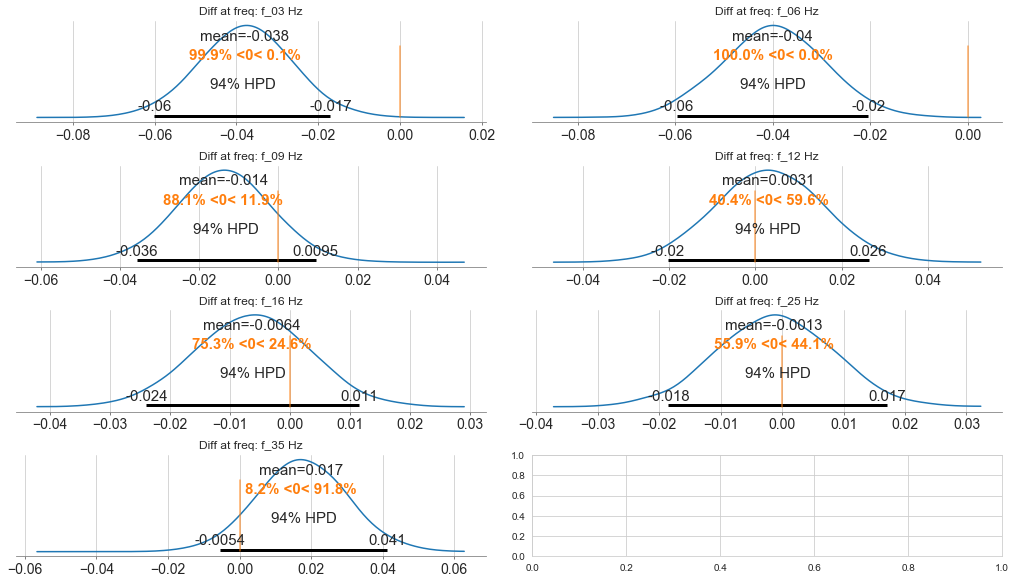

In [368]:
state1, state2 = 'state2', 'state3'
chan_id = 12
cortype = "ispc"
trace = pmc_chan_average(state1, state2, chan_id, cortype="ispc" )
plot_mean_diff(trace, [chan_id], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1779.25draws/s]


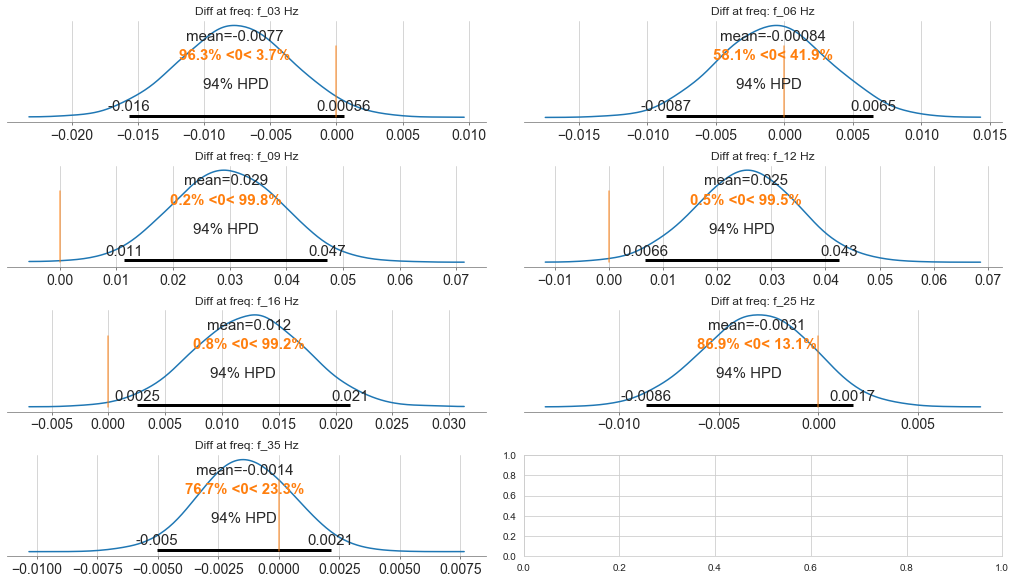

In [369]:
#тоже самое, но для другого способа вычисления синхронизации
state1, state2 = 'state2', 'state3'
chan_id = 12
cortype = "pli"
trace = pmc_chan_average(state1, state2, chan_id, cortype=cortype)
plot_mean_diff(trace, [chan_id], cortype)

можно посмотреть теперь что внутри этого канала для этого состояния

In [394]:
print(chans_to_explore(chan_of_interest, "ispc", "states_32"))
print(chans_to_explore(chan_of_interest, "pli", "states_32"))            

[[[12, 14], 0.5694104729490799], [[12, 16], 0.505478051126556]]
[]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2242.32draws/s]


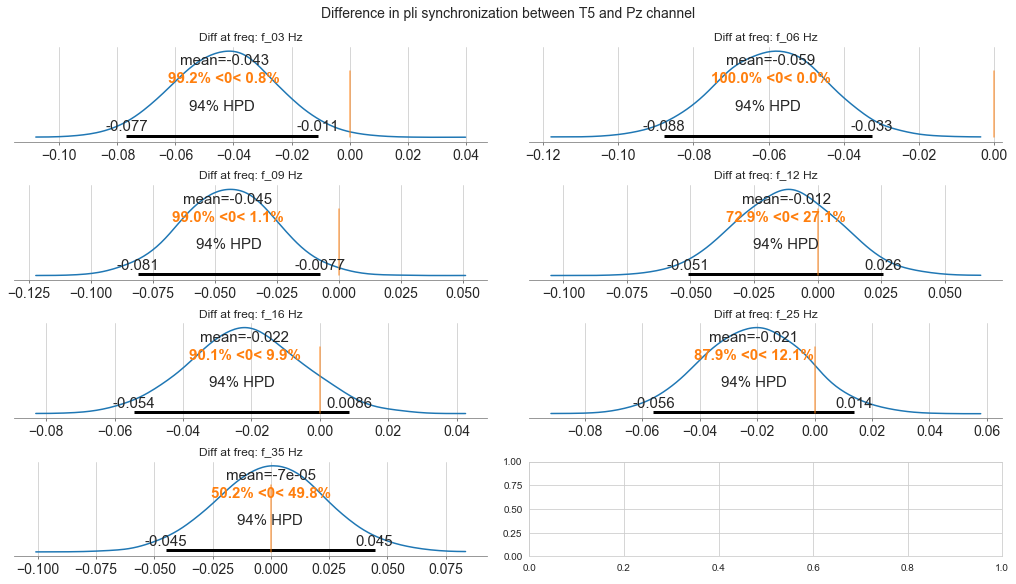

In [395]:
trace = pmc_chan2chan(state1, state2, 12, 14, cortype="ispc" )
plot_mean_diff(trace, [12,14], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2200.88draws/s]


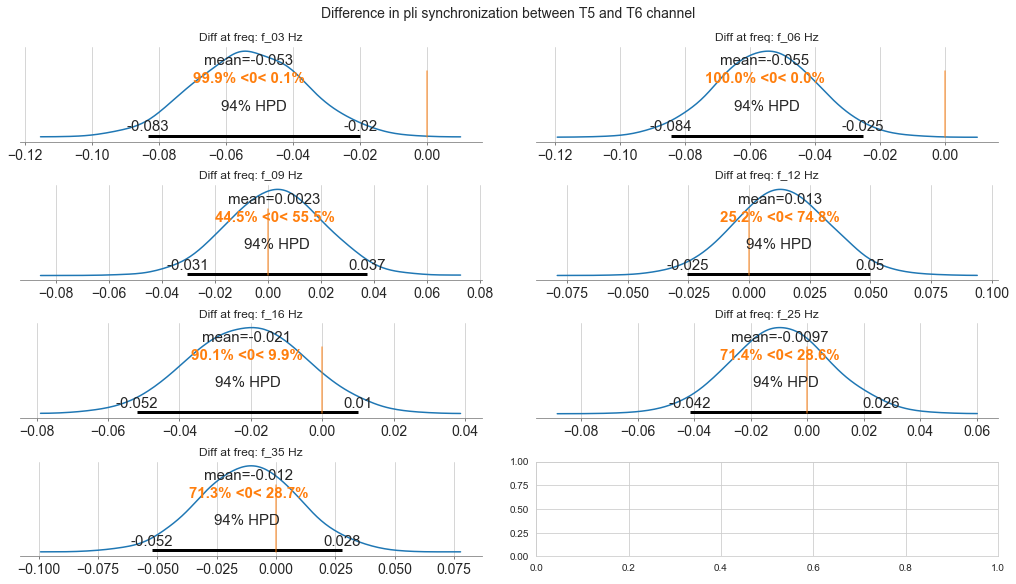

In [396]:
trace = pmc_chan2chan(state1, state2, 12, 16, cortype="ispc" )
plot_mean_diff(trace, [12,16], cortype)

### Канал 6 (F8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2048.67draws/s]


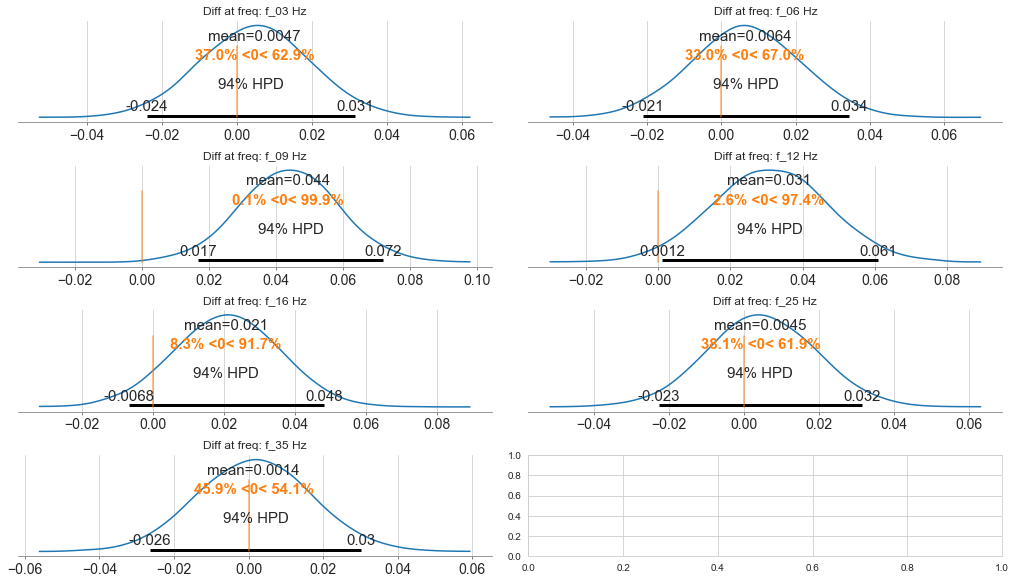

In [398]:
chan_id = 6
cortype = "ispc"
trace = pmc_chan_average(state1, state2, chan_id, cortype=cortype)
plot_mean_diff(trace, [chan_id], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:07<00:00, 1560.93draws/s]


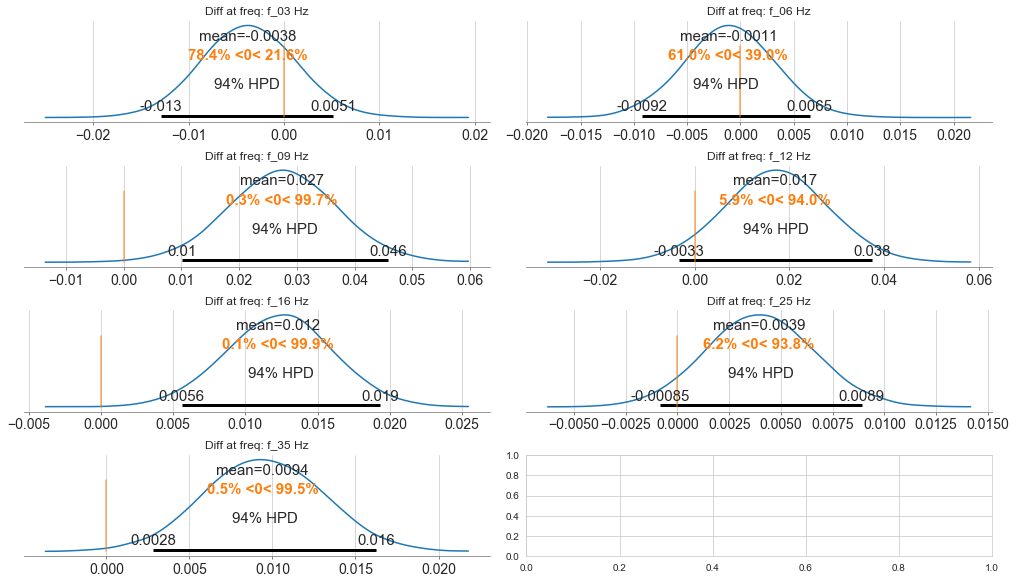

In [399]:
cortype = "pli"
trace = pmc_chan_average(state1, state2, chan_id, cortype=cortype)
plot_mean_diff(trace, [chan_id], cortype)

In [400]:
print(chans_to_explore(6, "ispc", "states_32"))
print(chans_to_explore(6, "pli", "states_32"))  

[[[0, 6], 0.5246887558367178]]
[[[6, 9], 0.5189053188240947], [[6, 17], 0.5101646872500388], [[6, 14], 0.5082542749146615]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2152.07draws/s]


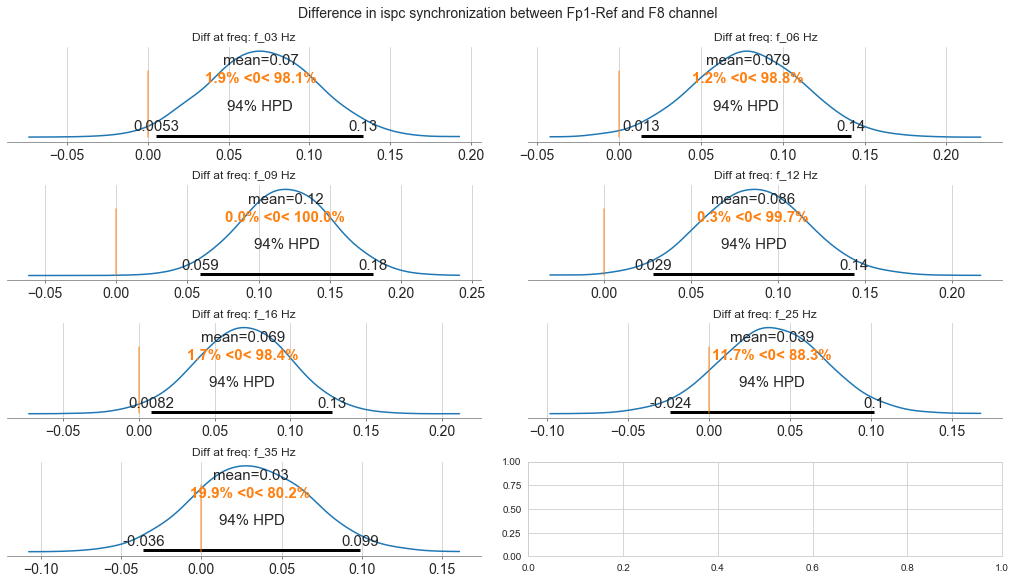

In [402]:
cortype = "ispc"
trace = pmc_chan2chan(state1, state2, 0, 6, cortype=cortype)
plot_mean_diff(trace, [0,6], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1931.83draws/s]


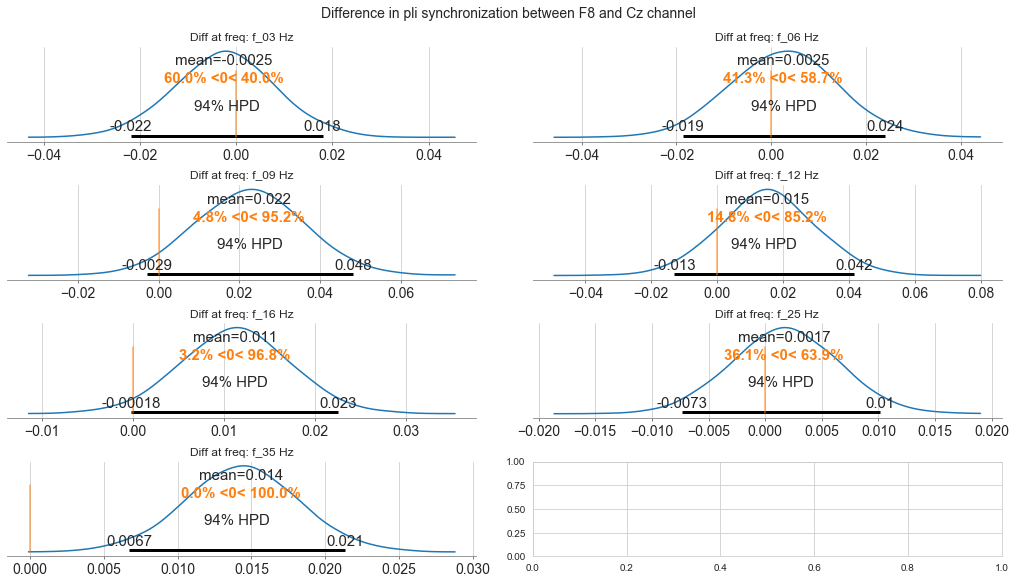

In [403]:
cortype = "pli"
trace = pmc_chan2chan(state1, state2, 6, 9, cortype=cortype)
plot_mean_diff(trace, [6, 9], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2082.83draws/s]


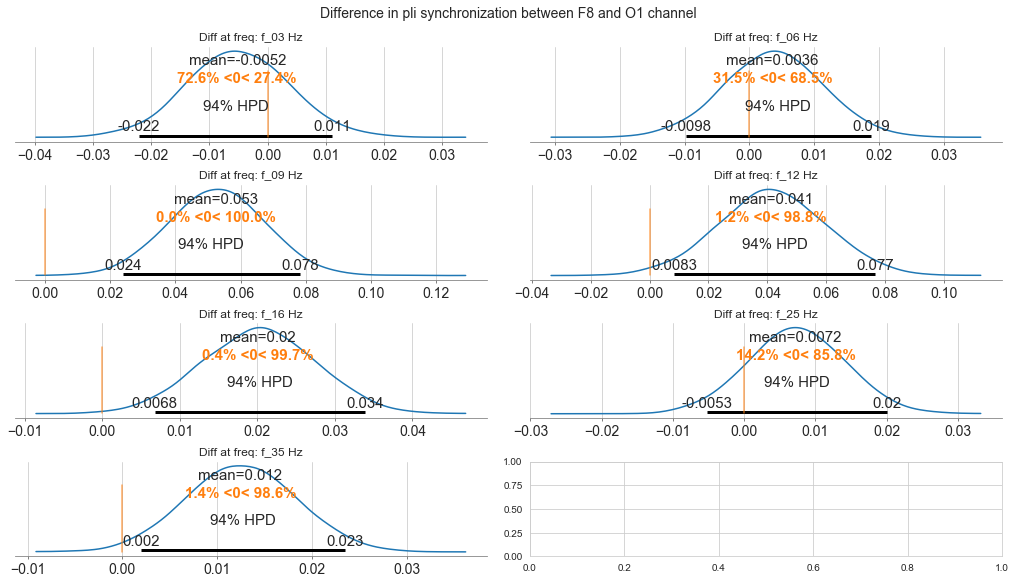

In [404]:
cortype = "pli"
trace = pmc_chan2chan(state1, state2, 6, 17, cortype=cortype)
plot_mean_diff(trace, [6, 17], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:07<00:00, 1658.17draws/s]


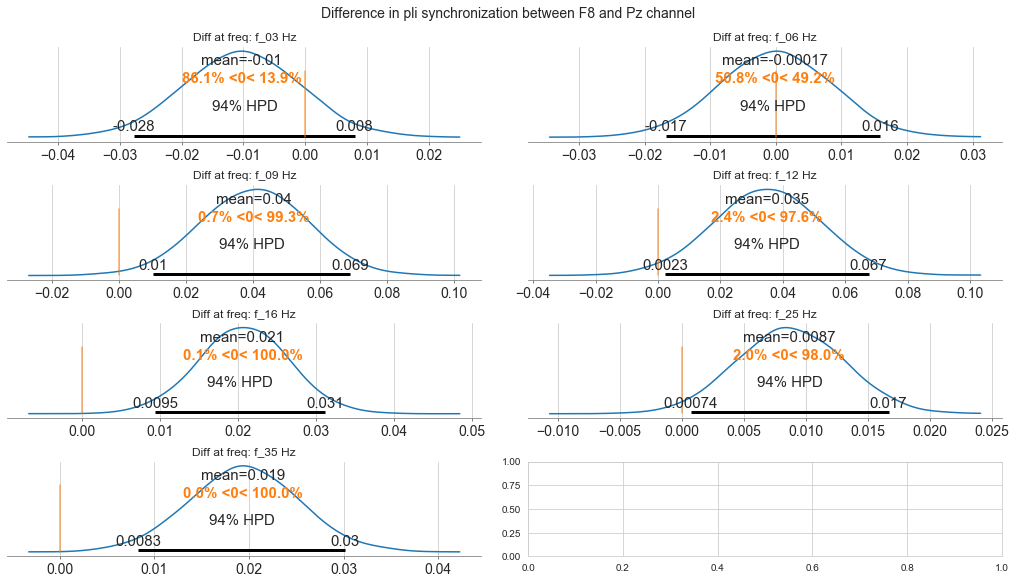

In [405]:
cortype = "pli"
trace = pmc_chan2chan(state1, state2, 6, 14, cortype=cortype)
plot_mean_diff(trace, [6, 14], cortype)

### Канал 17 (O1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1950.36draws/s]


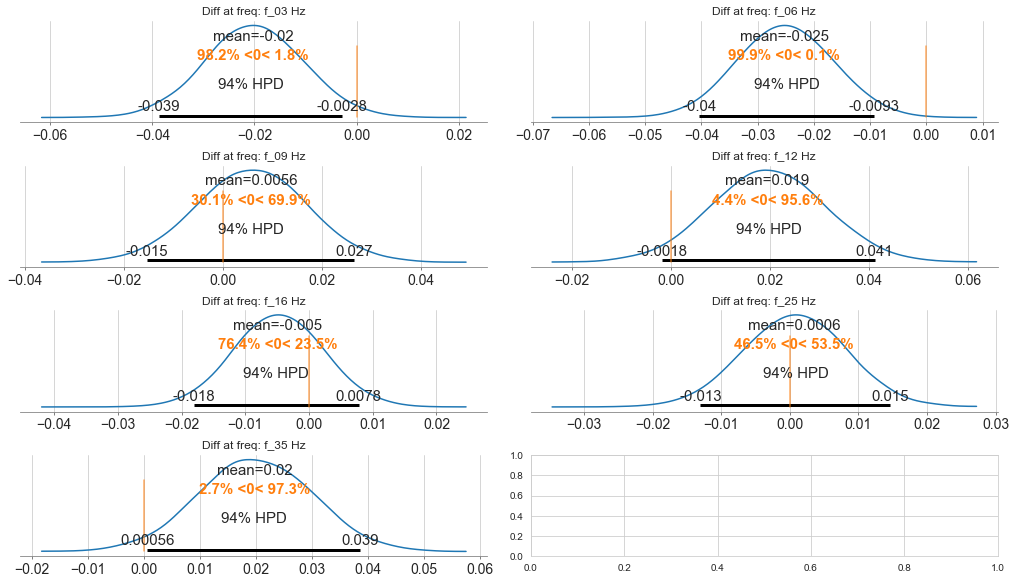

In [407]:
chan_id = 17
cortype = "ispc"
trace = pmc_chan_average(state1, state2, chan_id, cortype=cortype)
plot_mean_diff(trace, [chan_id], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1766.74draws/s]


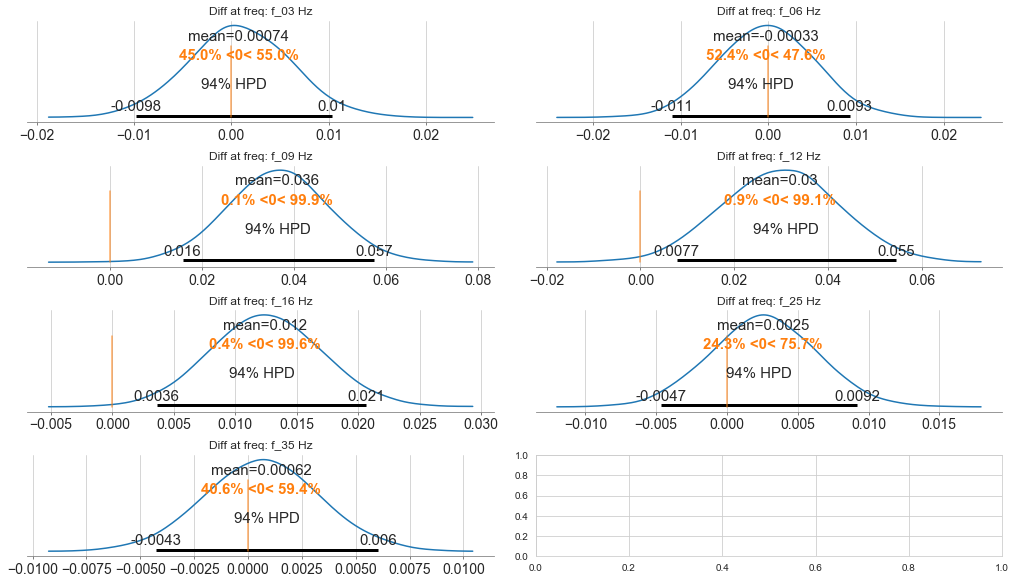

In [408]:
cortype = "pli"
trace = pmc_chan_average(state1, state2, chan_id, cortype=cortype)
plot_mean_diff(trace, [chan_id], cortype)

In [409]:
print(chans_to_explore(17, "ispc", "states_32"))
print(chans_to_explore(17, "pli", "states_32")) 

[[[13, 17], 0.529313165300687], [[0, 17], 0.5096842025060536]]
[[[6, 17], 0.5101646872500388], [[1, 17], 0.5057995702882058]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2014.05draws/s]


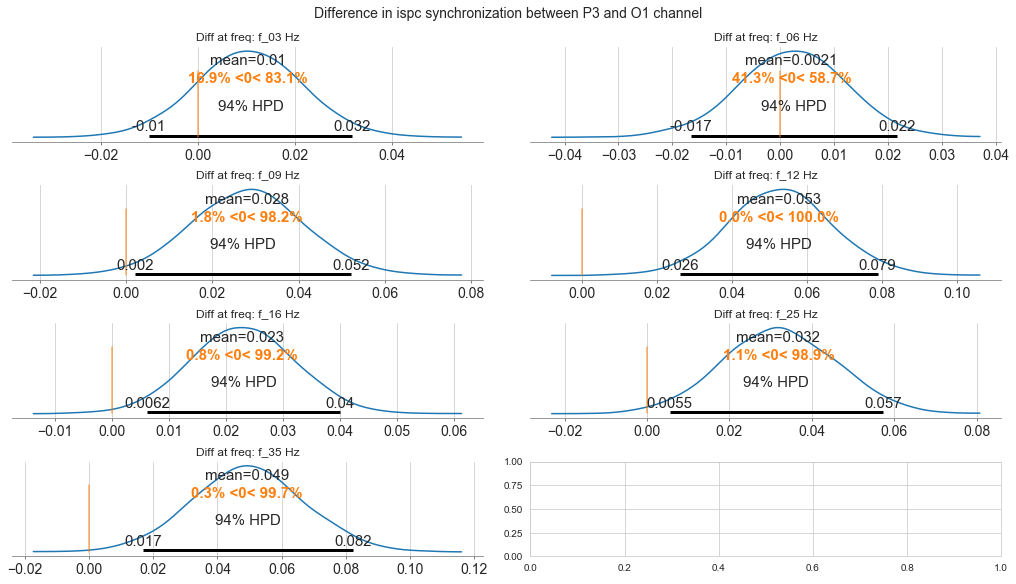

In [410]:
cortype = "ispc"
trace = pmc_chan2chan(state1, state2, 13, 17, cortype=cortype)
plot_mean_diff(trace, [13,17], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2096.10draws/s]


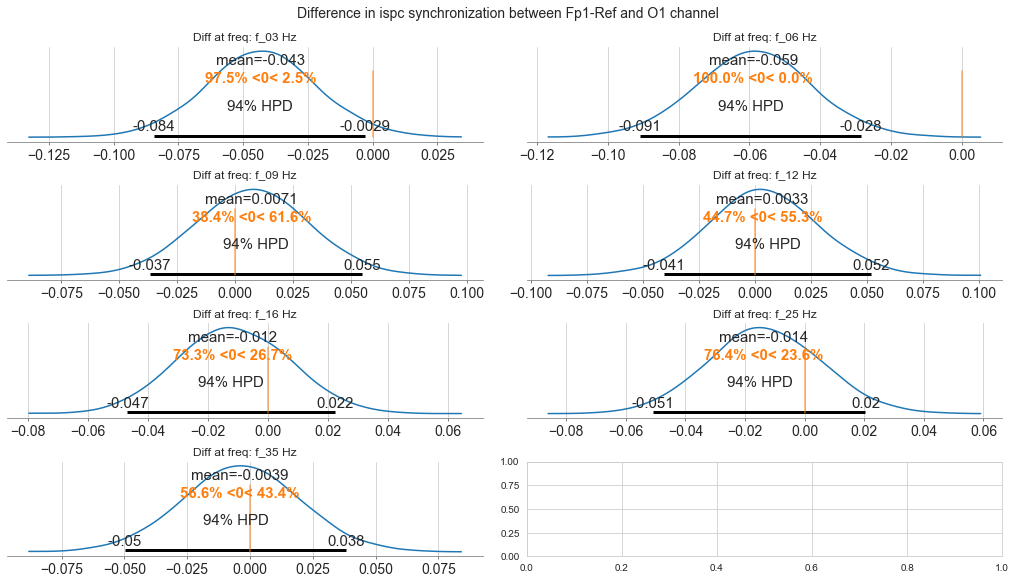

In [411]:
cortype = "ispc"
trace = pmc_chan2chan(state1, state2, 0, 17, cortype=cortype)
plot_mean_diff(trace, [0,17], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1870.44draws/s]


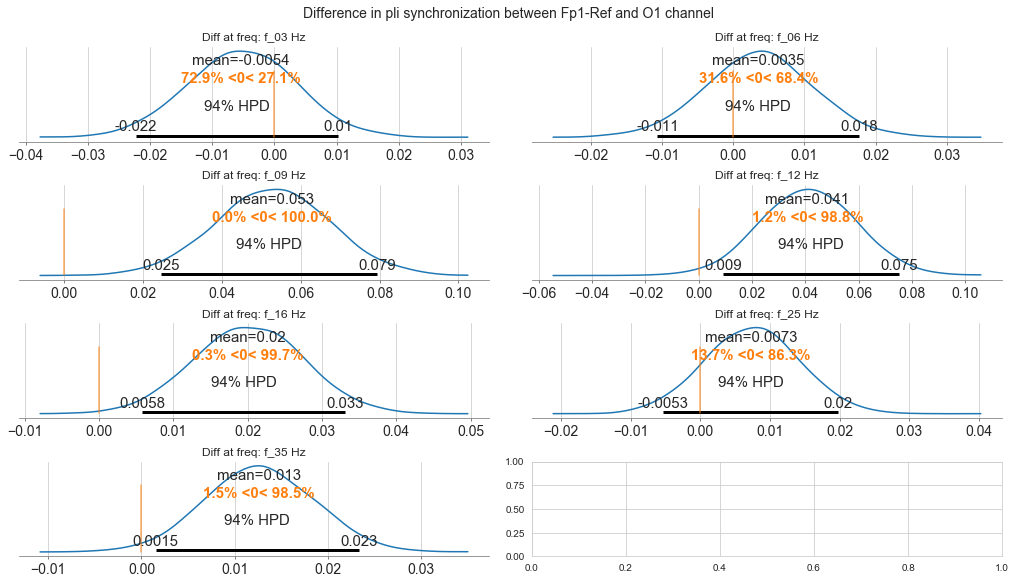

In [414]:
cortype = "pli"
trace = pmc_chan2chan(state1, state2, 6, 17, cortype=cortype)
plot_mean_diff(trace, [0,17], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:06<00:00, 1807.65draws/s]


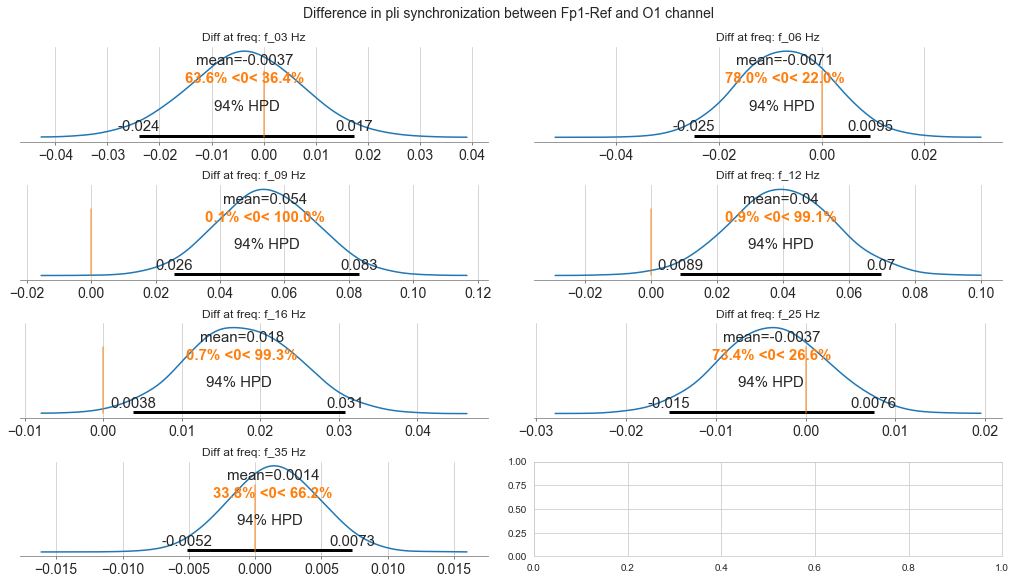

In [413]:
cortype = "pli"
trace = pmc_chan2chan(state1, state2, 1, 17, cortype=cortype)
plot_mean_diff(trace, [0,17], cortype)

## Состояние глаза закрыты в темноте - глаза открыты на свету

In [418]:
state1, state2 = 'state1', 'state3'

In [419]:
print(sorted(candidates_chan_pli['states31'], key=lambda x: x[1], reverse=True)[:5])
print(sorted(candidates_chan_ispc['states31'], key=lambda x: x[1], reverse=True)[:5])

[(18, 1.0682616024632257), (14, 1.0157497616486177), (16, 0.961691868239944), (15, 0.9270735472335009), (17, 0.8983288308580192)]
[(6, 1.1777157178521465), (1, 1.1459312451248116), (0, 1.0569299041999898), (2, 1.0385096998408279), (3, 0.8539954528949985)]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:07<00:00, 1660.40draws/s]


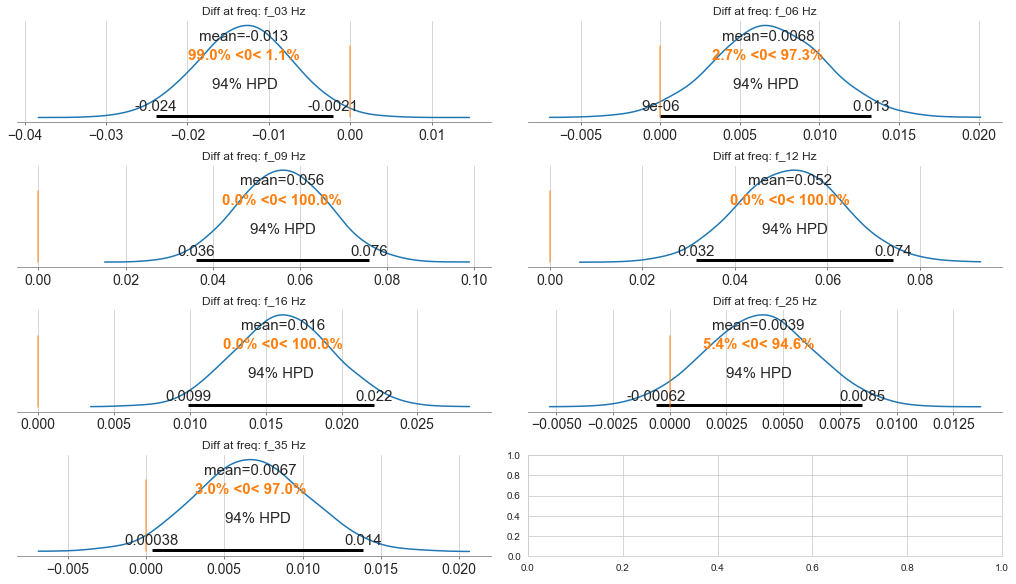

In [420]:
chan_id = 6
cortype = "pli"
trace = pmc_chan_average(state1, state2, chan_id, cortype=cortype)
plot_mean_diff(trace, [chan_id], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2079.58draws/s]


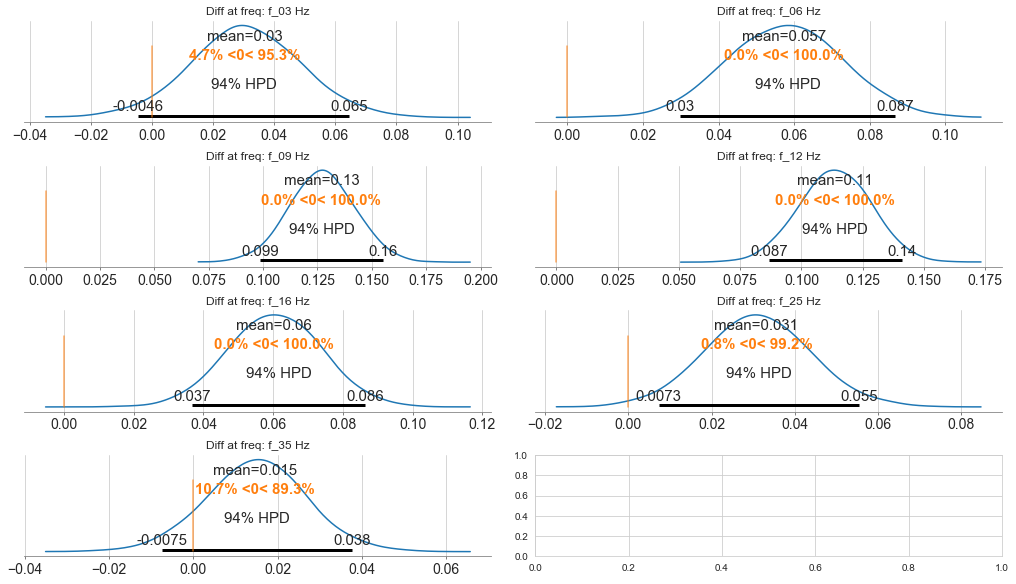

In [421]:
chan_id = 6
cortype = "ispc"
trace = pmc_chan_average(state1, state2, chan_id, cortype=cortype)
plot_mean_diff(trace, [chan_id], cortype)

In [422]:
print(chans_to_explore(6, "ispc", "states31"))
print(chans_to_explore(6, "pli", "states31")) 

[[[0, 6], 1.2413945428469788], [[3, 6], 1.1435311292751904], [[4, 6], 1.0967410964978925], [[2, 6], 0.9856888290743108], [[6, 17], 0.9752080157486817], [[1, 6], 0.9450089642812867], [[5, 6], 0.9232182299559757], [[6, 12], 0.7792302960213557], [[6, 13], 0.7546969115553778], [[6, 8], 0.7488419187182174], [[6, 9], 0.619829482344294], [[6, 14], 0.5934848633031728], [[6, 18], 0.54987819893978], [[6, 7], 0.5127221884941167]]
[[[6, 18], 0.7662727408983083], [[6, 17], 0.7483924574966596], [[6, 14], 0.72189696425692], [[6, 15], 0.7127091035628502], [[6, 10], 0.7038764978998253], [[6, 12], 0.6354380421846781], [[6, 13], 0.6313834144058554], [[6, 11], 0.5673665639095796], [[6, 9], 0.5557232208702977]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2174.24draws/s]


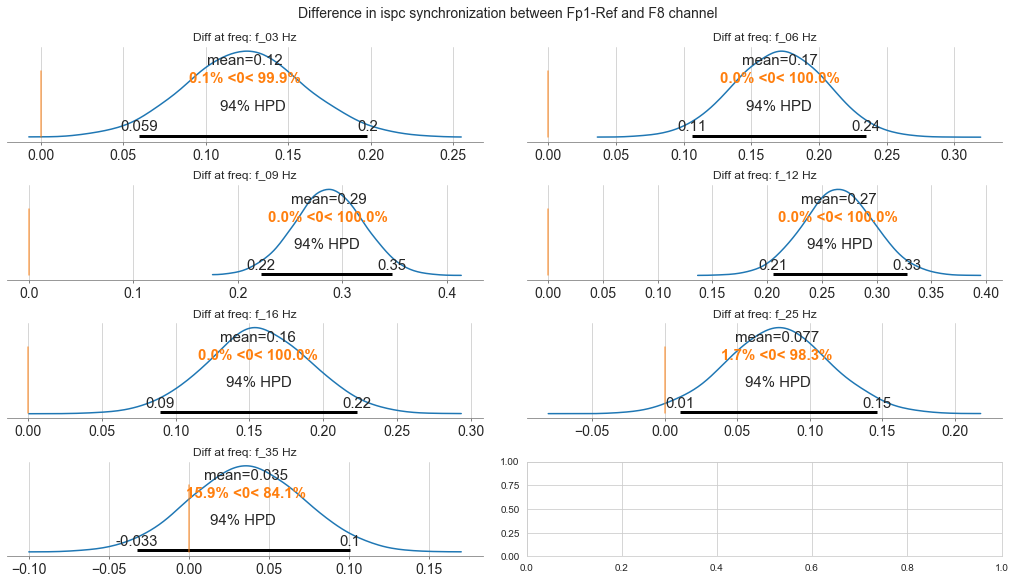

In [423]:
cortype = "ispc"
trace = pmc_chan2chan(state1, state2, 0, 6, cortype=cortype)
plot_mean_diff(trace, [0,6], cortype)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2282.80draws/s]


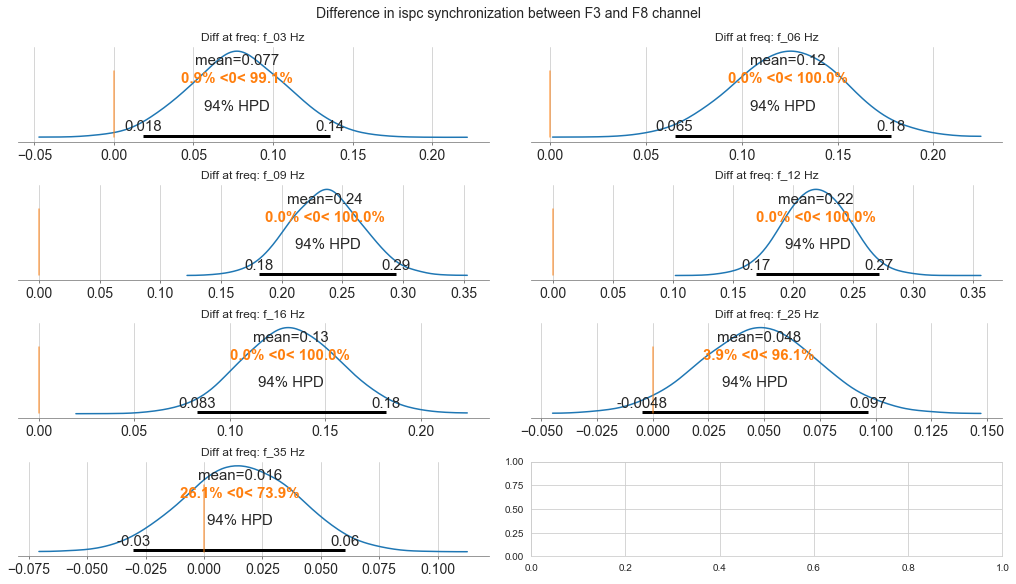

In [424]:
trace = pmc_chan2chan(state1, state2, 3, 6, cortype=cortype)
plot_mean_diff(trace, [3,6], cortype)